In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using Theano backend.


In [2]:
#data = pd.read_csv("data/samples/113_t_air.csv")
data = np.load('data/113_28_all.npy')

In [3]:
X = data[:,:13,:]
date_features = data[:,14:17,0]
y = data[:, 18:, :]

# dates = data["time_now"]

In [4]:
print (X.shape)
print (y.shape)

(6040, 13, 5)
(6040, 4, 5)


In [5]:
class My3DScaler:
    def __init__(self, feature_range):
        self.feature_range = feature_range
    def fit(self, X):
        self.shape = X.shape
        assert len(self.shape) == 3
        self.n_scalers = self.shape[2]
        self.scalers=[]
        for i in range(self.n_scalers):
            scaler = MinMaxScaler(feature_range=self.feature_range)
            scaler.fit(X[:,:,i])
            self.scalers.append(scaler)
    def transform(self, X):
        assert self.shape == X.shape
        X_ = np.zeros_like(X)
        for i in range(self.n_scalers):
            print '---'
            print X[:,:,i]
            print '---'
            X_[:,:,i] = self.scalers[i].transform(X[:,:,i])
        return X_

    def fit_transform(self, X):
        self.shape = X.shape
        self.scalers = []
        X_ = np.zeros_like(X)
        for i in range(self.shape[2]):
#             print '---'
#             print X[:,:,i]
#             print '---'
            scaler = MinMaxScaler(feature_range=self.feature_range)
            X_[:,:,i] = scaler.fit_transform(X[:,:,i])
            self.scalers.append(scaler)
        return X_
    def inverse_transform(self, X):
        #assert self.shape == X.shape
        X_ = np.zeros_like(X)
        for i in range(self.shape[2]):
            X_[:,:,i] = self.scalers[i].inverse_transform(X[:,:,i])
        return X_
        

In [6]:
scaller_t = My3DScaler(feature_range=(0, 1))
scaller_yt = My3DScaler(feature_range=(0, 1))
scaller_date_features = MinMaxScaler(feature_range=(0,1))
# scaller_hour = MinMaxScaler(feature_range=(0, 1))
# scaller_day_from = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaller_t.fit_transform(X)
y_scaled = scaller_yt.fit_transform(y)
features_scaled = scaller_date_features.fit_transform(date_features)
#scaller_hour.fit(X[:, 14])
#scaller_day_from.fit(X[:, 13])

In [7]:
y_ = y.copy()

In [8]:
X_scaled.shape

(6040, 13, 5)

In [9]:
train_size = 4800
X_train, y_train = np.array(X_scaled)[:train_size], np.array(y_scaled)[:train_size]
X_test, y_test   = np.array(X_scaled)[train_size:], np.array(y_scaled)[train_size:]
features_train = np.array(features_scaled)[:train_size]
features_test = np.array(features_scaled)[train_size:]
#test_dates = np.array(dates)[train_size:]

In [10]:
X.shape

(6040, 13, 5)

In [11]:
date_features.shape

(6040, 3)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(features_train.shape)
print(features_test.shape)

(4800, 13, 5)
(4800, 4, 5)
(1240, 13, 5)
(1240, 4, 5)
(4800, 3)
(1240, 3)


In [25]:
from keras.models import Sequential
from keras import optimizers
#from keras.layers.core import Dropout, Dense
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers import BatchNormalization, Conv1D
from keras.layers import LSTM, Input
from keras.models import Model
from keras.optimizers import Adam


#model.add(Flatten())



main_input = Input(shape=(13,5), dtype='float32', name='main_input')
lstm_out = LSTM(5, return_sequences=True, input_shape=(13, 5))(main_input)
conv1 = Conv1D(25, 13, activation='relu')(lstm_out)
flat = Flatten()(conv1)
features_input = Input(shape=(3,), name='features_input')
x = keras.layers.concatenate([flat, features_input])
x = Dense(20)(x)
x = Dropout(0.25)(x)
x = Dense(20)(x)
x = Reshape((4, 5))(x)
main_output = x
model = Model(inputs=[main_input, features_input], outputs=main_output)


In [26]:
model.compile(loss='mean_absolute_error', optimizer='adam')

In [27]:
model.fit([X_train, features_train], y_train, epochs=30, batch_size=1, shuffle=True)

Epoch 1/30
4800/4800 [==============================] - 6s - loss: 0.1124     
Epoch 2/30
4800/4800 [==============================] - 6s - loss: 0.0693     
Epoch 3/30
4800/4800 [==============================] - 6s - loss: 0.0612     
Epoch 4/30
4800/4800 [==============================] - 6s - loss: 0.0583     
Epoch 5/30
4800/4800 [==============================] - 6s - loss: 0.0575     
Epoch 6/30
4800/4800 [==============================] - 6s - loss: 0.0569     
Epoch 7/30
4800/4800 [==============================] - 6s - loss: 0.0558     
Epoch 8/30
4800/4800 [==============================] - 6s - loss: 0.0547     
Epoch 9/30
4800/4800 [==============================] - 6s - loss: 0.0547     
Epoch 10/30
4800/4800 [==============================] - 6s - loss: 0.0544     
Epoch 11/30
4800/4800 [==============================] - 6s - loss: 0.0541     
Epoch 12/30
4800/4800 [==============================] - 6s - loss: 0.0538     
Epoch 13/30
4800/4800 [==========================

In [28]:
from tqdm import tqdm
batch_array = [1, 13, 65, 130, 650, 1300]
for batch_size in tqdm(batch_array[1:]):
    model.fit([X_train, features_train], y_train, epochs=600, batch_size=batch_size, 
              shuffle=True, verbose=0)
    print(model.evaluate([X_train, features_train], y_train, batch_size=1))

  0%|          | 0/5 [00:00<?, ?it/s]

4756/4800 [============================>.] - ETA: 0s

 20%|██        | 1/5 [06:13<24:52, 373.14s/it]

0.0331483580909
4751/4800 [============================>.] - ETA: 0s

 40%|████      | 2/5 [08:07<14:46, 295.64s/it]

0.0312744813363
4727/4800 [============================>.] - ETA: 0s

 60%|██████    | 3/5 [09:29<07:42, 231.42s/it]

0.0294132325502
4689/4800 [============================>.] - ETA: 0s

 80%|████████  | 4/5 [10:30<03:00, 180.26s/it]

0.029798010481
4709/4800 [============================>.] - ETA: 0s

100%|██████████| 5/5 [11:28<00:00, 143.69s/it]

0.0294990401556


In [18]:
model.evaluate([X_train, features_train], y_train, batch_size=1)

4685/4800 [============================>.] - ETA: 0s

0.02857729910761312

In [24]:
model.evaluate([X_train, features_train], y_train, batch_size=1)

4690/4800 [============================>.] - ETA: 0s

0.031678186784265566

In [ ]:
model.save('model_loss_0252.h5')
model.save_weights('my_model_weights_loss_0252.h5')

In [29]:
y_pred_train = scaller_yt.inverse_transform(model.predict([X_train, features_train]))
y_pred_test = scaller_yt.inverse_transform(model.predict([X_test, features_test]))

y_columns = ['t_air', 't_road', 't_underroad', 'dampness', 'pressure']

for i in range(len(y_columns)):
    print 'Train for '+y_columns[i]

    print 'MSE=',mse(scaller_yt.inverse_transform(y_train)[:,:,i], y_pred_train[:,:,i])
    print 'MAE=',mae(scaller_yt.inverse_transform(y_train)[:,:,i], y_pred_train[:,:,i])

    print '--------------------------------------------'
    print 'Test for '+y_columns[i]
    
    print 'MSE=', mse(scaller_yt.inverse_transform(y_test)[:,:,i], y_pred_test[:,:,i])
    print 'MAE=', mae(scaller_yt.inverse_transform(y_test)[:,:,i], y_pred_test[:,:,i])
    print '============================================'

Train for t_air
MSE= 290.740770473
MAE= 12.4270634839
--------------------------------------------
Test for t_air
MSE= 1271.79471833
MAE= 27.6452111019
Train for t_road
MSE= 241.208098951
MAE= 11.7163751502
--------------------------------------------
Test for t_road
MSE= 1189.34753815
MAE= 27.8579049267
Train for t_underroad
MSE= 535.76577598
MAE= 16.1243359397
--------------------------------------------
Test for t_underroad
MSE= 2337.27482007
MAE= 36.215961291
Train for dampness
MSE= 5259.43062773
MAE= 48.6917343042
--------------------------------------------
Test for dampness
MSE= 18962.1039679
MAE= 105.502580571
Train for pressure
MSE= 60.8318558332
MAE= 5.98398238676
--------------------------------------------
Test for pressure
MSE= 94.2767604221
MAE= 7.24323707685


In [33]:
y_train_pred = scaller_yt.inverse_transform(model.predict(X_train))

t_air_test = scaller_yt.inverse_transform(y_test)[:1000]
t_air_train = scaller_yt.inverse_transform(y_train)[:1000]
t_air_train_pred = y_train_pred[:1000]
t_air_pred = y_pred[:1000]
plot_dates = test_dates[:1000]

In [34]:
for i, date in enumerate(plot_dates):
    plot_dates[i] = time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S").timetuple())

In [35]:
t_air_test.shape
plot_dates.shape

(1000,)

In [36]:
def draw_pred_vs_test(y_pred, y_test):
    #fig, plt = 
    
    #plt.plot(scaler.inverse_transform(dataset))
    
    plt.plot_date(t_air_test, )
    plt.plot(t_air_pred)
    plt.show()

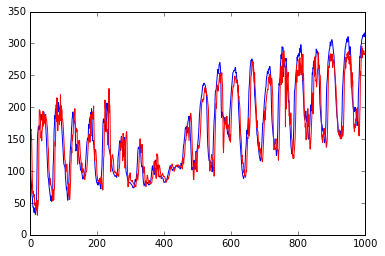

In [38]:
#plt.plot(scaler.inverse_transform(dataset))
#plt.plot_date(plot_dates, t_air_test[:, 0])
plt.plot(t_air_test[:, 2], c="b")
plt.plot(t_air_pred[:, 2], c="r")
plt.show()

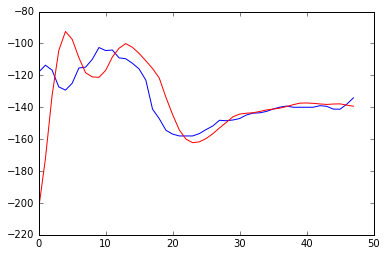

In [420]:
#plt.plot(scaler.inverse_transform(dataset))
#plt.plot_date(plot_dates, t_air_test[:, 0])
plt.plot(t_air_train[:,0], c="b")
plt.plot(t_air_train_pred[:,0]-17, c="r")
plt.show()

In [256]:
y_test

array([[ 115.8246968 ,   88.03577325,   69.71145374,   58.73759647],
       [  98.97574421,   81.18181818,   61.73112948,   49.1707989 ],
       [  88.03577325,   69.71145374,   58.73759647,   43.110011  ],
       ..., 
       [ 243.11678832,  245.79264948,  239.2484815 ,  247.86218302],
       [ 246.88760331,  243.54295154,  242.45975744,  245.44928335],
       [ 245.79264948,  239.2484815 ,  247.86218302,  236.3094195 ]])

In [257]:
model.predict(X_test)

array([[ 52651.41015625,  52363.9609375 ,  51878.98046875,  51191.12109375],
       [ 41257.921875  ,  40669.90625   ,  39934.5859375 ,  39047.22265625],
       [ 28499.31835938,  27718.32421875,  26849.4140625 ,  25887.13085938],
       ..., 
       [ 81690.65625   ,  81481.7265625 ,  80954.09375   ,  80101.6328125 ],
       [ 79205.78125   ,  78930.2578125 ,  78347.1015625 ,  77450.34375   ],
       [ 79811.5703125 ,  79558.46875   ,  78998.1875    ,  78123.71875   ]], dtype=float32)

In [209]:
scaller_yt.inverse_transform(y_train)

array([[  64.09851403,  104.11339359,  119.42021526,  139.0867052 ],
       [  83.89975349,  113.5240992 ,  132.25261324,  145.52766309],
       [ 104.11339359,  119.42021526,  139.0867052 ,  149.10152473],
       ..., 
       [ 167.19207485,  139.38567493,   98.97574421,   81.18181818],
       [ 160.14325069,  115.8246968 ,   88.03577325,   69.71145374],
       [ 139.38567493,   98.97574421,   81.18181818,   61.73112948]])

In [265]:
np.min(X_train)

0.0

In [101]:
model.fit_generator((X_train, y_train),
    steps_per_epoch=50,
    epochs=40,
    callbacks=[checkpoint_cb],
    validation_data=(X_test, y_test),
    validation_steps=100)

Epoch 1/40


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/user/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/user/anaconda2/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/user/anaconda2/lib/python2.7/site-packages/keras/engine/training.py", line 612, in data_generator_task
    generator_output = next(self._generator)
TypeError: tuple object is not an iterator



ValueError: output of generator should be a tuple `(x, y, sample_weight)` or `(x, y)`. Found: None

In [18]:
#ft_model.load_weights("weights.vgg19_Arsen.0.9588.hdf5", by_name=True)

IOError: Unable to open file (Unable to open file: name = 'weights.vgg19_arsen.0.9588.hdf5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [11]:
for i in range(15):
    print "N of layers: ", i
    for layer in ft_model.layers:
        layer.trainable = True 

    for layer in ft_model.layers[:-1]:
        layer.trainable = False

    ft_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    #ft_model.summary()

    ft_model.fit_generator(train_generator,
        steps_per_epoch=50,
        epochs=40,
        callbacks=[checkpoint_cb],
        validation_data=test_generator,
        validation_steps=100)

N of layers:  4
Epoch 1/40


Exception in thread Thread-3:
Traceback (most recent call last):
  File "/home/user/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/user/anaconda2/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/user/anaconda2/lib/python2.7/site-packages/keras/engine/training.py", line 612, in data_generator_task
    generator_output = next(self._generator)
  File "/home/user/anaconda2/lib/python2.7/site-packages/keras/preprocessing/image.py", line 950, in next
    index_array, current_index, current_batch_size = next(self.index_generator)
  File "/home/user/anaconda2/lib/python2.7/site-packages/keras/preprocessing/image.py", line 710, in _flow_index
    current_index = (self.batch_index * batch_size) % n
ZeroDivisionError: integer division or modulo by zero



ValueError: output of generator should be a tuple `(x, y, sample_weight)` or `(x, y)`. Found: None

In [12]:
ft_model.load_weights("weights.vgg19_Arsen.0.9599.hdf5", by_name=True)

In [13]:
import os
from tqdm import tqdm_notebook
from keras.preprocessing.image import load_img, img_to_array


def load_cropped(path):
    img = img_to_array(load_img(path, target_size=(224,224)))[np.newaxis, :]
    return preprocess_imagenet(img)

base_path = '../Data/Test-cropped/'

correct = 0
final_predictions = np.empty((1000, 2))

for k in tqdm_notebook(range(1000)):
    label = 'cats/' if os.path.isfile(base_path + 'cats/' + str(k) + '.jpg') \
                    or os.path.isfile(base_path + 'cats/' + str(k) + '.jpg.nonsquare') \
            else 'dogs/'
    
    current_path = base_path + label
    
    prediction = None
    answer = None
    
    if os.path.isfile(current_path + str(k) + '.jpg'):
        img = load_cropped(current_path + str(k) + '.jpg')
        prediction = ft_model.predict(img)
        answer = prediction.argmax()
        np.copyto(final_predictions[k], prediction)
        
    if os.path.isfile(current_path + str(k) + '.jpg.nonsquare'):
        predictions = []
        predictions.append(ft_model.predict(load_cropped(current_path + str(k) + '_l.jpg')))
        predictions.append(ft_model.predict(load_cropped(current_path + str(k) + '_r.jpg')))

        if os.path.isfile(current_path + str(k) + '_c.jpg'):
            predictions.append(ft_model.predict(load_cropped(current_path + str(k) + '_c.jpg')))

        answer = sum(predictions).argmax()
        np.copyto(final_predictions[k], sum(predictions) / len(predictions))
    
    if answer == (1 if label == 'cats/' else 0):
        correct += 1
        


In [15]:
np.save('../Submissions_Arsen/vgg19_2.npy', final_predictions)
#9600 - 95.3
#958* - 95.7
#9599 - 95.5
print('Accuracy: %.3f' % (correct * 100 / 1000.))

Accuracy: 95.500


In [58]:
answer = final_predictions

with open('../Submissions_Arsen/vgg19_3.csv', 'w') as f:
    f.write('file,label\n')
    for k,y in enumerate(answer):
        f.write(str(k) + '.jpg,' + ('cat' if y == 1 else 'dog') + '\n')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [16]:
#pred_vgg19 = np.load('../Submissions_Arsen/vgg19.npy')
pred_vgg19_2 = np.load('../Submissions_Arsen/vgg19_2.npy')
pred_vgg19_3 = np.load('../Submissions_Arsen/vgg19_3.npy')


answer = (pred_vgg19_2 + pred_vgg19_3).argmax(1)

with open('../Submissions_Arsen/ens2_new.csv', 'w') as f:
    f.write('file,label\n')
    for k,y in enumerate(answer):
        f.write(str(k) + '.jpg,' + ('cat' if y == 1 else 'dog') + '\n')

In [18]:
!cat ../Submissions_Arsen/ens2_new.csv

file,label
0.jpg,cat
1.jpg,cat
2.jpg,cat
3.jpg,cat
4.jpg,dog
5.jpg,dog
6.jpg,dog
7.jpg,dog
8.jpg,cat
9.jpg,cat
10.jpg,cat
11.jpg,cat
12.jpg,cat
13.jpg,dog
14.jpg,dog
15.jpg,dog
16.jpg,dog
17.jpg,cat
18.jpg,dog
19.jpg,dog
20.jpg,dog
21.jpg,cat
22.jpg,dog
23.jpg,dog
24.jpg,cat
25.jpg,dog
26.jpg,cat
27.jpg,dog
28.jpg,dog
29.jpg,dog
30.jpg,dog
31.jpg,cat
32.jpg,dog
33.jpg,cat
34.jpg,cat
35.jpg,dog
36.jpg,cat
37.jpg,cat
38.jpg,cat
39.jpg,dog
40.jpg,cat
41.jpg,dog
42.jpg,dog
43.jpg,dog
44.jpg,cat
45.jpg,cat
46.jpg,dog
47.jpg,dog
48.jpg,cat
49.jpg,cat
50.jpg,dog
51.jpg,dog
52.jpg,cat
53.jpg,dog
54.jpg,cat
55.jpg,cat
56.jpg,cat
57.jpg,dog
58.jpg,dog
59.jpg,cat
60.jpg,dog
61.jpg,dog
62.jpg,cat
63.jpg,cat
64.jpg,cat
65.jpg,dog
66.jpg,cat
67.jpg,cat
68.jpg,dog
69.jpg,dog
70.jpg,dog
71.jpg,cat
72.jpg,cat
73.jpg,dog
74.jpg,cat
75.jpg,cat
76.jpg,dog
77.jpg,dog
78.jpg,cat
79.jpg,dog
80.jpg,dog
81.jpg,cat
82.jpg,dog
83.jpg,cat
84.jpg,dog
85.jpg,cat
86.jpg,cat
87.jpg,dog
88.jpg,cat
89.jpg,cat
90.jpg,ca